In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Ignore all warnings
warnings.filterwarnings("ignore")



<h2>
Process the Metadata

In [2]:
path = '/Users/wenyuanchen/Desktop/IBM/IBM_Tumor_Project/Data/autoPETmeta.csv'
raw_meta_df = pd.read_csv(path)
raw_meta_df.fillna('unknown', inplace=True)
raw_meta_df[['patient_id','study_id']] = raw_meta_df['study_location'].str.rsplit('/', n=2, expand=True)[[0,1]]
raw_meta_df['patient_id'] = raw_meta_df['patient_id'].str.split('/').str[-1]

def get_diagnosis(raw_meta_df = raw_meta_df):
    raw_df = raw_meta_df.copy()
    diagnosis_dict = {(row['patient_id'], row['study_id']): row['diagnosis'] for index, row in raw_df.iterrows()}
    return diagnosis_dict

def read_diagnosis_sample_patient_id(raw_meta_df = raw_meta_df,diagnosis = "NEGATIVE"):
    raw_df = raw_meta_df.copy()

    diagnosis_id_lst = raw_df[raw_df['diagnosis'] == diagnosis]['patient_id']
    diagnosis_study_lst = raw_df[raw_df['diagnosis'] == diagnosis]['study_id']
    return diagnosis_id_lst, diagnosis_study_lst


In [3]:
patient_study_counts = raw_meta_df.groupby('patient_id')['study_id'].nunique()
patients_with_multiple_studies = patient_study_counts[patient_study_counts > 1]

# The length of this filtered series gives us the number of Patient IDs with more than 1 unique Study ID
number_of_patients_more_than_1_study = len(patients_with_multiple_studies)
number_of_patients_more_than_1_study
print(f'There are {number_of_patients_more_than_1_study} patients with more than 1 study.')

There are 81 patients with more than 1 study.


In [4]:
# Find patients with negative diagnosis
negative_patients = set(raw_meta_df[raw_meta_df['diagnosis'] == 'NEGATIVE']['patient_id'])

# Find patients with positive diagnosis
positive_patients = set(raw_meta_df[raw_meta_df['diagnosis'] != 'NEGATIVE']['patient_id'])

# Find patients that are in both negative diagnosis and other positive diagnosis
cross_diagnosis_patients = negative_patients.intersection(positive_patients)

cross_diagnosis_patients
print(f"Number of patients that have more than 1 diagnosis: {len(cross_diagnosis_patients)}")

Number of patients that have more than 1 diagnosis: 30


In [5]:
diagnosis_dict = get_diagnosis(raw_meta_df = raw_meta_df)

In [6]:
negative_id_lst, negative_study_lst = read_diagnosis_sample_patient_id()

<h2>
Process the generated csv and EDA

In [7]:
path = '../all_patients_final_results_with_26_new_connected_components.csv'
# path = '../all_patients_results.csv'
raw_df = pd.read_csv(path)
print(f'raw_df shape: {raw_df.shape}')
raw_df.groupby(['Patient ID', 'Study ID']).size()
num_unique_patients = raw_df.groupby(['Patient ID']).size()
assert num_unique_patients.shape[0] == 900

num_unique_studies = raw_df.groupby(['Patient ID', 'Study ID']).size()
assert num_unique_studies.shape[0] == 1014

# Create a new column called 'Diagnosis' in the raw_df
tuples = list(zip(raw_df['Patient ID'], raw_df['Study ID']))
# Now map these tuples to their corresponding diagnosis using the diagnosis_dict
raw_df['Diagnosis'] = pd.Series(tuples).map(diagnosis_dict)


raw_df shape: (9133, 9)


In [8]:
remove_negative_sample_df = raw_df[raw_df['Diagnosis'] != 'NEGATIVE']
# remove_negative_sample_df
# remove_negative_sample_df['np.prod(pixdim)'] = np.round(remove_negative_sample_df['Physical Vol(cm^3)']*1000/remove_negative_sample_df['Pixel Vol'],2)

In [9]:
tumor_less_than_0_6_in_diameter_df = remove_negative_sample_df[remove_negative_sample_df['In Diameter(cm)']< 0.6]
tumor_less_than_0_6_in_diameter_and_suv_max_less_than_3_df = tumor_less_than_0_6_in_diameter_df[tumor_less_than_0_6_in_diameter_df['SUV Max'] < 3]
# filtered_non_clinical_important_tumor_df = remove_negative_sample_df[(remove_negative_sample_df['In Diameter(cm)']> 0.6) & (remove_negative_sample_df['SUV Max'] > 2.5)]
# tumor_less_than_0_6_in_diameter_df = remove_negative_sample_df[(remove_negative_sample_df['In Diameter(cm)']<= 0.6) & (remove_negative_sample_df['SUV Max'] <= 2.5)]
# suspicious_small_tumor_df = tumor_less_than_0_6_in_diameter_df[tumor_less_than_0_6_in_diameter_df['SUV Max'] > 2.5]
filtered_non_clinical_important_tumor_df = remove_negative_sample_df[~remove_negative_sample_df.index.isin(tumor_less_than_0_6_in_diameter_and_suv_max_less_than_3_df.index)]
filtered_non_clinical_important_tumor_df

# filtered_non_clinical_important_tumor_df = remove_negative_sample_df.isNotin(tumor_less_than_0_6_in_diameter_df)
# filtered_non_clinical_important_tumor_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.3476,5.2787,2.0571,16.1041,MELANOMA
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,59,0.7340,1.1192,4.7366,2.0748,12.3759,MELANOMA
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,41,0.5101,0.9913,3.2053,2.0643,5.9694,MELANOMA
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,280,3.4835,1.8808,4.9858,2.0629,15.4478,MELANOMA
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.6865,7.3036,2.0607,19.6536,MELANOMA
...,...,...,...,...,...,...,...,...,...,...
9126,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,85,123,1.5302,1.4297,3.6867,2.0710,7.7638,LYMPHOMA
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,85,1.0575,1.2640,3.6395,2.0594,9.8709,LYMPHOMA
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,100,1.2441,1.3344,2.8568,2.0629,5.6163,LYMPHOMA
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,75,0.9331,1.2124,3.3243,2.0933,5.3749,LYMPHOMA


In [10]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Pixel Vol']<=3]

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
9,PETCT_01140d52d8,08-13-2005-NA-PET-CT Ganzkoerper primaer mit ...,5,2,0.0249,0.3622,3.2864,3.1884,3.3845,MELANOMA
10,PETCT_01140d52d8,08-13-2005-NA-PET-CT Ganzkoerper primaer mit ...,6,1,0.0124,0.2875,3.0760,3.0760,3.0760,MELANOMA
40,PETCT_02ba7e20f5,10-12-2001-NA-PET-CT Ganzkoerper primaer mit ...,7,3,0.0373,0.4146,3.3370,3.2832,3.3838,MELANOMA
77,PETCT_06e7c24059,04-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,4,1,0.0124,0.2875,3.1446,3.1446,3.1446,MELANOMA
174,PETCT_0beb67c923,07-25-1999-NA-PET-CT Ganzkoerper primaer mit ...,3,3,0.0373,0.4146,3.2215,3.1867,3.2857,LYMPHOMA
...,...,...,...,...,...,...,...,...,...,...
8785,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,19,1,0.0124,0.2875,3.1193,3.1193,3.1193,LYMPHOMA
8875,PETCT_f5c9b0de6c,04-02-2004-NA-PET-CT Ganzkoerper primaer mit ...,60,3,0.0373,0.4146,3.3167,3.1520,3.4498,MELANOMA
8888,PETCT_f5c9b0de6c,04-02-2004-NA-PET-CT Ganzkoerper primaer mit ...,73,2,0.0249,0.3622,4.2781,4.2370,4.3192,MELANOMA
8889,PETCT_f5c9b0de6c,04-02-2004-NA-PET-CT Ganzkoerper primaer mit ...,74,1,0.0124,0.2875,3.1555,3.1555,3.1555,MELANOMA


In [25]:
tumor_less_than_0_6_in_diameter_df[tumor_less_than_0_6_in_diameter_df['Patient ID'] == "PETCT_f21755a99b"]

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
8770,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,4,1,0.0124,0.2875,2.0604,2.0604,2.0604,LYMPHOMA
8771,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,5,3,0.0373,0.4146,2.0876,2.0690,2.0984,LYMPHOMA
8776,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,10,5,0.0622,0.4916,3.4609,3.1740,3.8316,LYMPHOMA
8778,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,12,6,0.0746,0.5224,3.6349,3.2517,4.0447,LYMPHOMA
8781,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,15,2,0.0249,0.3622,3.2861,3.0926,3.4796,LYMPHOMA
8783,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,17,3,0.0373,0.4146,3.2340,3.0976,3.4152,LYMPHOMA
8784,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,18,1,0.0124,0.2875,3.0917,3.0917,3.0917,LYMPHOMA
8785,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,19,1,0.0124,0.2875,3.1193,3.1193,3.1193,LYMPHOMA


In [23]:
filtered_non_clinical_important_tumor_df[(filtered_non_clinical_important_tumor_df['Pixel Vol']<=3) 
                                         &(filtered_non_clinical_important_tumor_df['Patient ID'] == "PETCT_f21755a99b")]

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
8781,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,15,2,0.0249,0.3622,3.2861,3.0926,3.4796,LYMPHOMA
8783,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,17,3,0.0373,0.4146,3.2340,3.0976,3.4152,LYMPHOMA
8784,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,18,1,0.0124,0.2875,3.0917,3.0917,3.0917,LYMPHOMA
8785,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,19,1,0.0124,0.2875,3.1193,3.1193,3.1193,LYMPHOMA


In [19]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'] == "PETCT_f21755a99b"]

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
8767,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,1,83,1.0326,1.2540,3.4510,2.0610,8.0391,LYMPHOMA
8768,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,2,75020,933.3254,12.1249,6.4035,2.0585,37.4361,LYMPHOMA
8769,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,3,264,3.2844,1.8443,3.8788,2.0638,8.8593,LYMPHOMA
8772,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,6,206,2.5629,1.6979,5.4477,3.1140,12.8027,LYMPHOMA
8773,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,7,352,4.3792,2.0299,9.7712,3.0971,30.3175,LYMPHOMA
8774,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,8,16,0.1991,0.7244,4.9936,3.1439,8.0935,LYMPHOMA
8775,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,9,127,1.5800,1.4451,6.1989,3.0913,16.7179,LYMPHOMA
8776,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,10,5,0.0622,0.4916,3.4609,3.1740,3.8316,LYMPHOMA
8777,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,11,13,0.1617,0.6760,3.7154,3.1119,4.5356,LYMPHOMA
8778,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,12,6,0.0746,0.5224,3.6349,3.2517,4.0447,LYMPHOMA


In [31]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['In Diameter(cm)'] == 16.0001]

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level
2250,PETCT_30001118d0,04-03-1999-NA-PET-CT Ganzkoerper primaer mit ...,22,172388,2144.6827,16.0001,7.1692,2.0569,25.7119,LYMPHOMA,>200,>10


In [15]:
filtered_non_clinical_important_tumor_df.describe()

,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
count,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000,8150.000000
mean,99.100368,1086.579018,13.518152,1.687368,4.698634,2.534469,12.215793
std,201.087016,5828.168602,72.508368,1.471177,2.315882,1.066561,12.445864
min,1.000000,1.000000,0.012400,0.287500,0.988200,0.094800,1.308200
25%,6.000000,28.000000,0.348300,0.873000,3.210475,1.974525,5.088825
50%,23.000000,94.000000,1.169500,1.307200,4.151900,2.627700,8.057150
75%,74.000000,306.000000,3.807000,1.937300,5.467450,3.209400,14.606725
max,1046.000000,172388.000000,2144.682700,16.000100,31.063800,6.974700,347.401500


In [16]:
tumor_less_than_0_6_in_diameter_df.describe()

,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
count,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,112.928380,3.231593,0.040191,0.398180,3.230737,3.082434,3.416063
std,193.818887,2.473147,0.030780,0.105004,0.987880,0.930825,1.126204
min,1.000000,1.000000,0.012400,0.287500,1.037100,0.844400,1.037500
25%,11.000000,1.000000,0.012400,0.287500,2.266550,2.158700,2.390550
50%,33.500000,2.000000,0.024900,0.362200,3.260700,3.150800,3.335900
75%,103.000000,5.000000,0.062200,0.491600,3.697000,3.416000,4.046650
max,1045.000000,9.000000,0.112000,0.598000,6.974700,6.974700,9.158200


In [12]:
tumor_less_than_0_6_in_diameter_df['Pixel Vol'].describe()

count    1494.000000
mean        3.231593
std         2.473147
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max         9.000000
Name: Pixel Vol, dtype: float64

In [17]:
filtered_cross_diag_patient_df = filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'].isin(cross_diagnosis_patients)]

In [18]:
filtered_cross_diag_patient_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
54,PETCT_05808cf24e,07-29-1999-NA-PET-CT Ganzkoerper nativ-42289,1,135,1.6795,1.4748,2.8277,2.0299,4.3792,LYMPHOMA
55,PETCT_05808cf24e,07-29-1999-NA-PET-CT Ganzkoerper nativ-42289,2,119,1.4805,1.4141,2.6180,2.0322,4.5249,LYMPHOMA
56,PETCT_05808cf24e,07-29-1999-NA-PET-CT Ganzkoerper nativ-42289,3,316,3.9314,1.9582,3.4227,2.0310,7.2331,LYMPHOMA
57,PETCT_05808cf24e,07-29-1999-NA-PET-CT Ganzkoerper nativ-42289,4,7225,89.8864,5.5577,3.6107,2.0287,7.0747,LYMPHOMA
58,PETCT_05808cf24e,07-29-1999-NA-PET-CT Ganzkoerper nativ-42289,5,54,0.6718,1.0866,2.7380,2.0462,3.8420,LYMPHOMA
...,...,...,...,...,...,...,...,...,...,...
9126,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,85,123,1.5302,1.4297,3.6867,2.0710,7.7638,LYMPHOMA
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,85,1.0575,1.2640,3.6395,2.0594,9.8709,LYMPHOMA
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,100,1.2441,1.3344,2.8568,2.0629,5.6163,LYMPHOMA
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,75,0.9331,1.2124,3.3243,2.0933,5.3749,LYMPHOMA


In [19]:
tumor_less_than_0_6_in_diameter_df.describe()

,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,27.379310,2.389163,0.029705,0.360472,2.053289,2.008041,2.100357
std,36.141067,2.052708,0.025553,0.091949,0.256703,0.282833,0.259184
min,1.000000,1.000000,0.012400,0.287500,1.037100,0.844400,1.037500
25%,6.000000,1.000000,0.012400,0.287500,2.067575,2.061750,2.071375
50%,14.000000,1.000000,0.012400,0.287500,2.120450,2.094650,2.137900
75%,30.000000,3.000000,0.037300,0.414600,2.194975,2.147900,2.247000
max,193.000000,9.000000,0.112000,0.598000,2.498000,2.498000,2.498000


<h3>
There are in total of 406 tumor being removed using diameter cut off = 0.6cm/6mm and suv max <= 2.5 

In [20]:
filtered_non_clinical_important_tumor_df.describe()

,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
count,8214.000000,8214.000000,8214.000000,8214.000000,8214.000000,8214.000000,8214.000000
mean,98.660823,1078.152057,13.413311,1.677931,4.680981,2.532088,12.141613
std,200.443572,5806.195019,72.234994,1.469321,2.315465,1.062950,12.425517
min,1.000000,1.000000,0.012400,0.287500,0.988200,0.094800,1.308200
25%,6.000000,27.000000,0.335900,0.862500,3.195125,2.003275,5.028725
50%,23.000000,92.000000,1.144600,1.297800,4.139800,2.620300,7.990200
75%,73.000000,302.000000,3.757200,1.928800,5.447550,3.207600,14.479075
max,1046.000000,172388.000000,2144.682700,16.000100,31.063800,6.974700,347.401500


In [16]:
def plot_level_(bins, labels, feature, df = filtered_non_clinical_important_tumor_df, hue = False, diagnosis_col = 'Diagnosis', in_place = False):
    if in_place:
        filtered_non_clinical_important_tumor_df = df
    else:
        filtered_non_clinical_important_tumor_df = df.copy()
    
    filtered_non_clinical_important_tumor_df[feature + ' Level'] = pd.cut(
    filtered_non_clinical_important_tumor_df[feature], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)
    if hue:
        # Create a cross-tabulation of diagnosis by feature levels
        diagnosis_by_level = pd.crosstab(
            filtered_non_clinical_important_tumor_df[feature + ' Level'], 
            filtered_non_clinical_important_tumor_df[diagnosis_col]
        )
        print(diagnosis_by_level)

        # Plot a stacked bar chart
        plt.figure(figsize=(10, 6))
        diagnosis_by_level.plot(kind='bar', stacked=True)

        plt.title('Frequency of Tumors by ' + feature + ' Level and Diagnosis', fontsize=16)
        plt.xlabel(feature + ' Level', fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        plt.xticks(rotation=45, fontsize=14)  # Rotate for better label readability
        plt.yticks(fontsize=14)
        plt.legend(title=diagnosis_col)
        plt.tight_layout()  # Adjust layout to prevent label cut-offs
        plt.show()
    else:
          # Count the frequency of each level without hue categorization
        plt.figure(figsize=(10, 6))
        level_counts = filtered_non_clinical_important_tumor_df[feature + ' Level'].value_counts().reindex(labels)
        level_counts.plot(kind='bar', color='skyblue')
        plt.title('Frequency of Tumors by ' + feature + ' Level', fontsize=16)
        plt.xlabel(feature + ' Level', fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        plt.xticks(rotation=0, fontsize = 16) 
        plt.yticks(fontsize = 16)
        plt.show()

In [68]:
0.1 *1000/12.44

8.038585209003216

In [62]:
bins = np.array([0, 2, 5, 10, 100, 200, float('inf')]) *1000/12.44
bins

array([    0.        ,   160.77170418,   401.92926045,   803.8585209 ,
        8038.585209  , 16077.17041801,            inf])

In [71]:
filtered_non_clinical_important_tumor_df.describe()

,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
count,7126.000000,7126.000000,7126.000000,7126.000000,7126.000000,7126.000000,7126.000000
mean,91.608336,1242.223267,15.454526,1.871176,4.835320,2.386848,13.398871
std,196.754906,6217.435659,77.351248,1.484885,2.430625,1.027827,12.880518
min,1.000000,10.000000,0.124400,0.619400,0.988200,0.094800,1.308200
25%,6.000000,45.250000,0.562925,1.024475,3.177325,1.551525,5.931325
50%,20.000000,124.000000,1.542700,1.433600,4.305550,2.138100,9.155400
75%,63.000000,373.000000,4.640500,2.069500,5.689725,3.129275,15.822075
max,1046.000000,172388.000000,2144.682700,16.000100,31.063800,6.105400,347.401500


Diagnosis                 LUNG_CANCER  LYMPHOMA  MELANOMA
Physical Vol(cm^3) Level                                 
0-0.1(8p)                           7       525       441
0.1-0.2(16P)                       31       222       258
0.2-2(160p)                       560      1252      1784
2-5 (400P)                        510       385       465
5-10(800P)                        237       168       186
10-100 (8000P)                    345       277       273
100-200(16000P)                    40        43        24
>200                               58        47        12


<Figure size 1000x600 with 0 Axes>

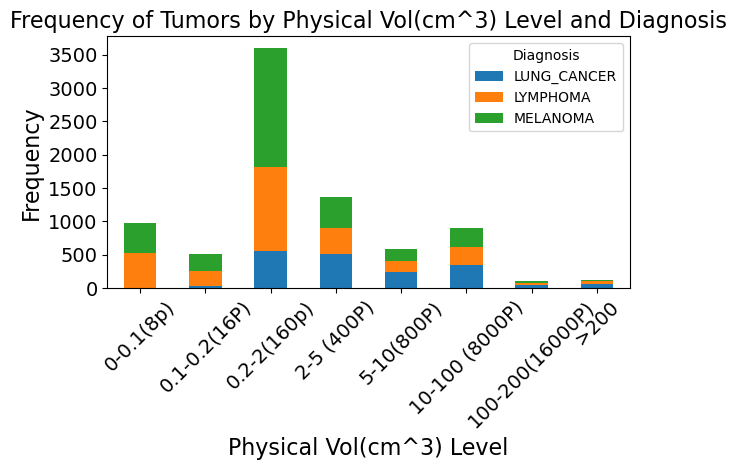

In [56]:
# Define the bins edges
# bins = [0, 10, 150, 400, 800,  float('inf')]

# # Define the labels for the bins
# labels = ['0-10', '10-150', '150-400', '400-800', '>800']

# plot_level_(bins, labels,'Pixel Vol', hue=True, in_place = True)

# Define the bins edges
bins = [0, 0.1, 0.2, 2, 5, 10, 100, 200, float('inf')]
# bins = [0.1, 0.2, 2, 5, 10, 100, 200, float('inf')]

# Define the labels for the bins
labels = ['0-0.1(8p)','0.1-0.2(16P)', '0.2-2(160p)', '2-5 (400P)', '5-10(800P)', '10-100 (8000P)', '100-200(16000P)', '>200']
# labels =['0.1-0.2(16P)', '0.2-2(160p)', '2-5 (400P)', '5-10(800P)', '10-100 (8000P)', '100-200(16000P)', '>200']

plot_level_(bins, labels, 'Physical Vol(cm^3)', hue=True, in_place = True)
# feature = 'Physical Vol(cm^3)'
# pd.cut(
#     filtered_non_clinical_important_tumor_df[feature], 
#     bins=bins, 
#     labels=labels, 
#     include_lowest=True
# ).loc[:10]
# nan_count = filtered_non_clinical_important_tumor_df[feature].isnull().sum()
# print(f'Number of NaN values in {feature}: {nan_count}')
# # Check for values outside the specified bins
# outside_bins = (~filtered_non_clinical_important_tumor_df[feature].between(bins[0], bins[-2])) & filtered_non_clinical_important_tumor_df[feature].notna()
# outside_count = outside_bins.sum()
# print(f'Number of values outside specified bins: {outside_count}')
# binned_series = pd.cut(filtered_non_clinical_important_tumor_df[feature], bins=bins, labels=labels, include_lowest=True)
# filtered_non_clinical_important_tumor_df[binned_series.isna()]


In [76]:
filtered_non_clinical_important_tumor_df[(filtered_non_clinical_important_tumor_df['Patient ID'] == 'PETCT_5d553bf6b4')]

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level
3670,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,1,1344,16.7207,3.1726,3.2317,1.2547,9.5480,LUNG_CANCER,10-100 (8000P),6-10
3671,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,2,5881,73.1656,5.1892,6.0897,1.0847,24.9319,LUNG_CANCER,10-100 (8000P),>10
3672,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,3,79,0.9828,1.2336,2.1575,1.4806,3.7021,LUNG_CANCER,0.2-2(160p),3-6
3673,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,4,68,0.8460,1.1734,2.1083,1.5314,4.2045,LUNG_CANCER,0.2-2(160p),3-6
3674,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,5,842,10.4753,2.7147,2.8177,1.3118,5.4917,LUNG_CANCER,10-100 (8000P),3-6
3675,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,6,21892,272.3588,8.0423,2.9181,0.8075,15.2721,LUNG_CANCER,>200,>10
3676,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,7,67,0.8335,1.1676,2.3988,1.4216,4.0156,LUNG_CANCER,0.2-2(160p),3-6
3678,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,9,284,3.5332,1.8897,2.2683,1.4008,3.8903,LUNG_CANCER,2-5 (400P),3-6
3680,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,11,112,1.3934,1.3858,2.2000,1.5149,4.0905,LUNG_CANCER,0.2-2(160p),3-6
3681,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,12,208,2.5877,1.7034,2.3482,1.1528,4.7673,LUNG_CANCER,2-5 (400P),3-6


In [75]:
filtered_non_clinical_important_tumor_df[(filtered_non_clinical_important_tumor_df['Patient ID'] == 'PETCT_5d553bf6b4') & (filtered_non_clinical_important_tumor_df['Pixel Vol'] <= 10)]

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level


In [67]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Pixel Vol'] <= 8][filtered_non_clinical_important_tumor_df['Patient ID'] == 'PETCT_0b57b247b6']


,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level


In [57]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Physical Vol(cm^3) Level'].isna()]


,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level


In [24]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Pixel Vol'] <= 3][filtered_non_clinical_important_tumor_df['Diagnosis'] == 'LYMPHOMA']

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
174,PETCT_0beb67c923,07-25-1999-NA-PET-CT Ganzkoerper primaer mit ...,3,3,0.0373,0.4146,3.2215,3.1867,3.2857,LYMPHOMA
186,PETCT_0cda25453b,10-12-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,2,0.0249,0.3622,5.7205,5.3211,6.1200,LYMPHOMA
188,PETCT_0cda25453b,10-12-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,1,0.0124,0.2875,5.3439,5.3439,5.3439,LYMPHOMA
210,PETCT_0cda25453b,10-12-2003-NA-PET-CT Ganzkoerper primaer mit ...,25,1,0.0124,0.2875,5.2020,5.2020,5.2020,LYMPHOMA
213,PETCT_0cda25453b,10-12-2003-NA-PET-CT Ganzkoerper primaer mit ...,28,2,0.0249,0.3622,5.3646,5.3545,5.3747,LYMPHOMA
...,...,...,...,...,...,...,...,...,...,...
8490,PETCT_ed9dca00d2,09-25-2004-NA-PET-CT Ganzkoerper primaer mit ...,7,1,0.0124,0.2875,3.2075,3.2075,3.2075,LYMPHOMA
8781,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,15,2,0.0249,0.3622,3.2861,3.0926,3.4796,LYMPHOMA
8783,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,17,3,0.0373,0.4146,3.2340,3.0976,3.4152,LYMPHOMA
8784,PETCT_f21755a99b,05-05-2005-NA-PET-CT Ganzkoerper primaer mit ...,18,1,0.0124,0.2875,3.0917,3.0917,3.0917,LYMPHOMA


In [40]:
bins = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]) *1000/12.44
bins

array([0.        , 1.60771704, 3.21543408, 4.82315113, 6.43086817,
       8.03858521, 9.64630225])

In [39]:
tumor_less_than_0_6_in_diameter_df.describe()

,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
count,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,112.928380,3.231593,0.040191,0.398180,3.230737,3.082434,3.416063
std,193.818887,2.473147,0.030780,0.105004,0.987880,0.930825,1.126204
min,1.000000,1.000000,0.012400,0.287500,1.037100,0.844400,1.037500
25%,11.000000,1.000000,0.012400,0.287500,2.266550,2.158700,2.390550
50%,33.500000,2.000000,0.024900,0.362200,3.260700,3.150800,3.335900
75%,103.000000,5.000000,0.062200,0.491600,3.697000,3.416000,4.046650
max,1045.000000,9.000000,0.112000,0.598000,6.974700,6.974700,9.158200


Diagnosis      LUNG_CANCER  LYMPHOMA  MELANOMA
SUV Max Level                                 
3-6                      5       344       261
6-10                     0         4         1


<Figure size 1000x600 with 0 Axes>

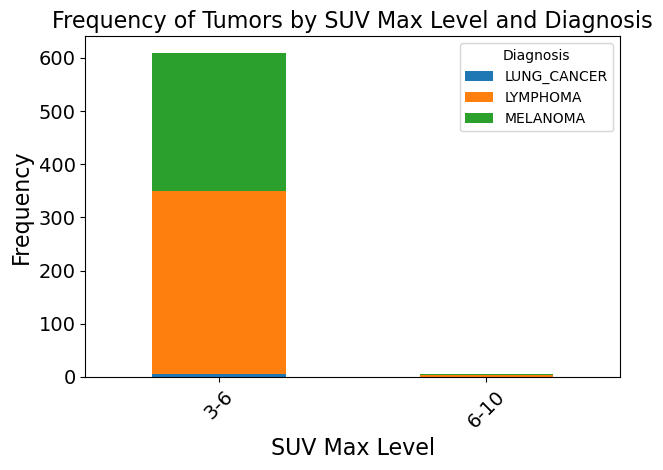

In [20]:
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]
# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']
df = filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Pixel Vol'] <= 3]
plot_level_(bins, labels, 'SUV Max', df = df, hue=True)



Diagnosis        LUNG_CANCER  LYMPHOMA  MELANOMA
Pixel Vol Level                                 
0-1                        3       179       142
1-2                        1       115        65
2-3                        1        54        55


<Figure size 1000x600 with 0 Axes>

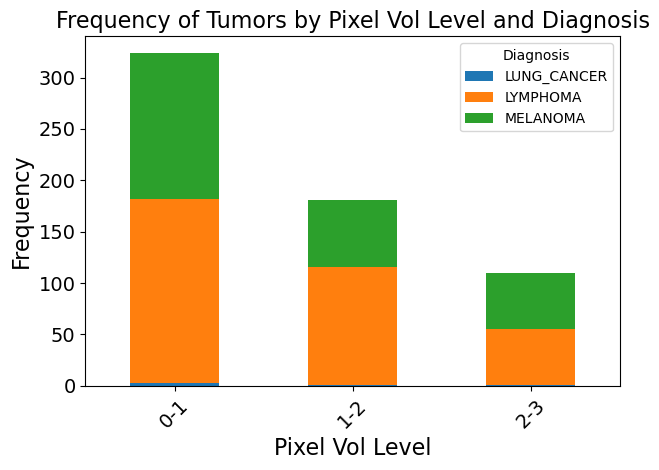

In [18]:
bins = [0, 1,2,3, float('inf')]
# labels = ['0-3', '>3']
labels = ['0-1', '1-2', '2-3', '>3']
plot_level_(bins, labels, 'Pixel Vol', hue=True, df = filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Pixel Vol'] <= 3])

<Figure size 1000x600 with 0 Axes>

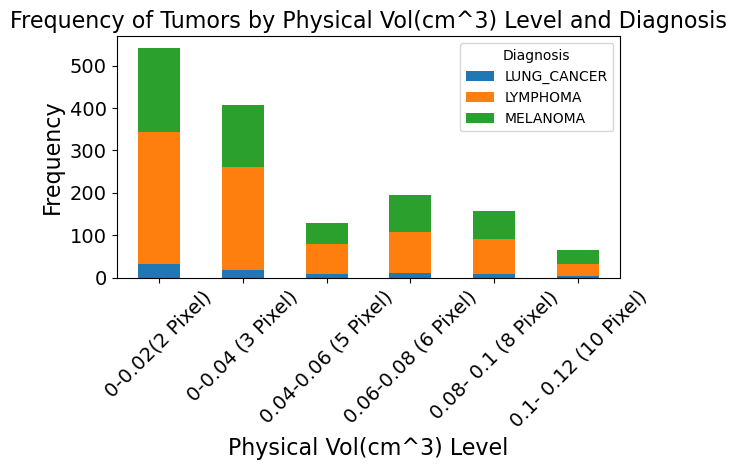

In [15]:

# Define the bins edges
bins = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]

# Define the labels for the bins
labels = ['0-0.02(2 Pixel)', '0-0.04 (3 Pixel)', '0.04-0.06 (5 Pixel)', '0.06-0.08 (6 Pixel)', '0.08- 0.1 (8 Pixel)', '0.1- 0.12 (10 Pixel)']

plot_level_(bins, labels, 'Physical Vol(cm^3)', df = tumor_less_than_0_6_in_diameter_df,hue=True, in_place = True)

<Figure size 1000x600 with 0 Axes>

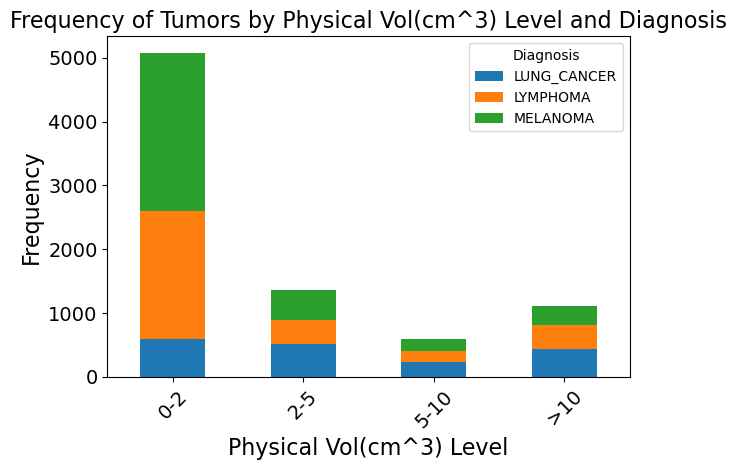

In [20]:
# Define the bins edges
bins = [0, 2, 5, 10, float('inf')]

# Define the labels for the bins
labels = ['0-2', '2-5', '5-10', '>10']

plot_level_(bins, labels, 'Physical Vol(cm^3)', hue=True, in_place = True)

<Figure size 1000x600 with 0 Axes>

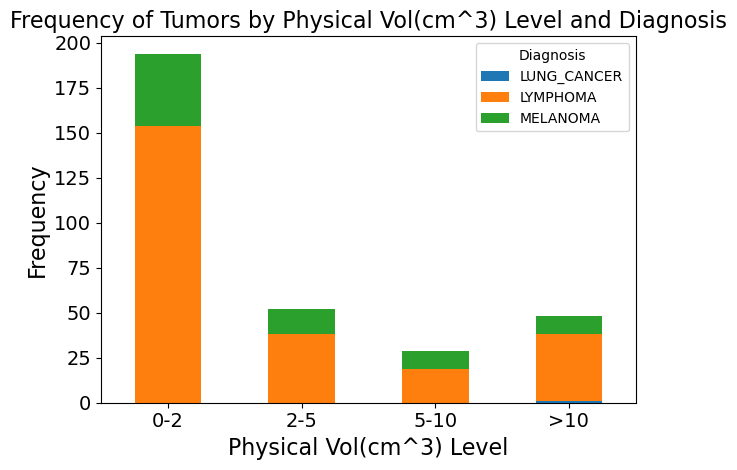

In [70]:
# Define the bins edges
bins = [0, 2, 5, 10, float('inf')]

# Define the labels for the bins
labels = ['0-2', '2-5', '5-10', '>10']

plot_level_(bins, labels, 'Physical Vol(cm^3)', df = filtered_cross_diag_patient_df, hue=True)

In [26]:
filtered_non_clinical_important_tumor_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.3476,5.2787,2.0571,16.1041,MELANOMA,0.2-2(160p),>10
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,59,0.7340,1.1192,4.7366,2.0748,12.3759,MELANOMA,0.2-2(160p),>10
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,41,0.5101,0.9913,3.2053,2.0643,5.9694,MELANOMA,0.2-2(160p),3-6
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,280,3.4835,1.8808,4.9858,2.0629,15.4478,MELANOMA,2-5 (400P),>10
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.6865,7.3036,2.0607,19.6536,MELANOMA,10-100 (8000P),>10
...,...,...,...,...,...,...,...,...,...,...,...,...
9126,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,85,123,1.5302,1.4297,3.6867,2.0710,7.7638,LYMPHOMA,0.2-2(160p),6-10
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,85,1.0575,1.2640,3.6395,2.0594,9.8709,LYMPHOMA,0.2-2(160p),6-10
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,100,1.2441,1.3344,2.8568,2.0629,5.6163,LYMPHOMA,0.2-2(160p),3-6
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,75,0.9331,1.2124,3.3243,2.0933,5.3749,LYMPHOMA,0.2-2(160p),3-6


<Figure size 1000x600 with 0 Axes>

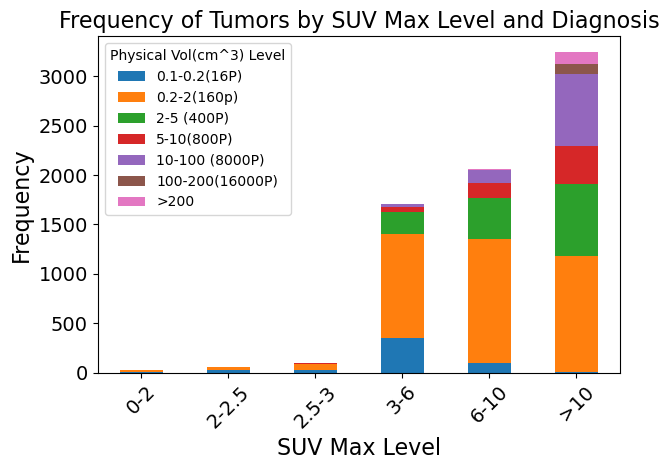

In [27]:
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]
# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']
plot_level_(bins, labels, 'SUV Max', hue = True, in_place = True, diagnosis_col= 'Physical Vol(cm^3) Level')


<Figure size 1000x600 with 0 Axes>

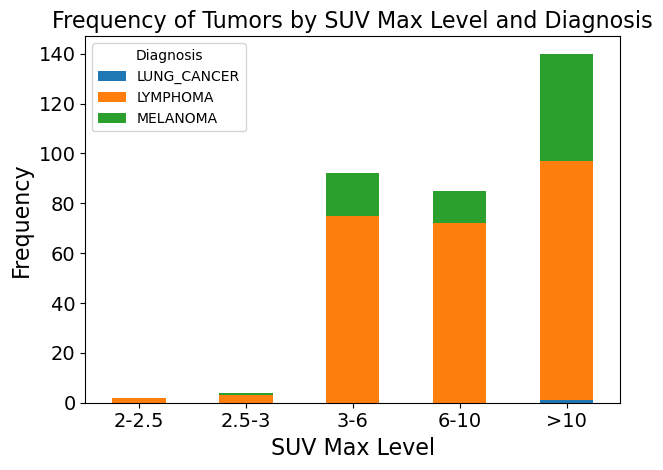

In [24]:
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]
# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']
plot_level_(bins, labels, 'SUV Max', df = filtered_cross_diag_patient_df, hue = True)


In [25]:
def plot_hist(feature, df = filtered_non_clinical_important_tumor_df):
    plt.figure(figsize=(10, 6))
    plt.hist(df[feature], bins=30, alpha=0.7, color='blue')
    plt.title('Frequency vs ' + feature, fontsize=16)
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.grid(True)
    plt.show()

# def plot_hist(feature, df = filtered_non_clinical_important_tumor_df):
#     plt.figure(figsize=(10, 6))
#     plt.hist(df[feature], bins=30, color='blue')
#     plt.title('Distribution of ' + feature, fontsize=16)
#     plt.xlabel(feature, fontsize=16)
#     plt.ylabel('Dis', fontsize=16)
#     plt.xticks(fontsize=16)
#     plt.yticks(fontsize=16)
#     plt.grid(True)
#     plt.show()
    

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.3476,5.2787,2.0571,16.1041,MELANOMA,0-2,>10
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,59,0.7340,1.1192,4.7366,2.0748,12.3759,MELANOMA,0-2,>10
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,41,0.5101,0.9913,3.2053,2.0643,5.9694,MELANOMA,0-2,3-6
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,280,3.4835,1.8808,4.9858,2.0629,15.4478,MELANOMA,2-5,>10
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.6865,7.3036,2.0607,19.6536,MELANOMA,>10,>10
...,...,...,...,...,...,...,...,...,...,...,...,...
9126,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,85,123,1.5302,1.4297,3.6867,2.0710,7.7638,LYMPHOMA,0-2,6-10
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,85,1.0575,1.2640,3.6395,2.0594,9.8709,LYMPHOMA,0-2,6-10
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,100,1.2441,1.3344,2.8568,2.0629,5.6163,LYMPHOMA,0-2,3-6
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,75,0.9331,1.2124,3.3243,2.0933,5.3749,LYMPHOMA,0-2,3-6


In [31]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Diagnosis'] == 'LUNG_CANCER'].describe()

,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
count,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000
mean,20.216171,1998.603593,24.864670,2.389954,3.112855,1.074156,10.697197
std,24.985566,7516.256459,93.509904,1.706918,1.285943,0.302734,12.363816
min,1.000000,10.000000,0.124400,0.619400,1.158600,0.094800,1.308200
25%,4.000000,122.000000,1.517800,1.425800,2.318000,0.861100,4.888000
50%,9.000000,270.000000,3.359100,1.858100,2.757100,1.073900,7.413700
75%,28.000000,798.000000,9.927900,2.666600,3.483600,1.303900,13.087600
max,131.000000,161209.000000,2005.604500,15.646400,13.851500,3.205300,347.401500


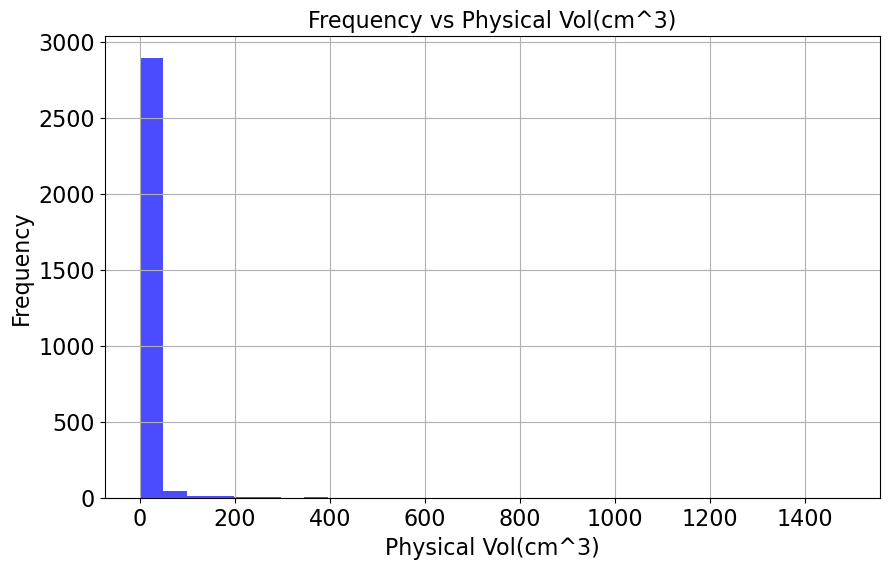

In [19]:
plot_hist('Physical Vol(cm^3)', df = filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Diagnosis'] == 'MELANOMA'])

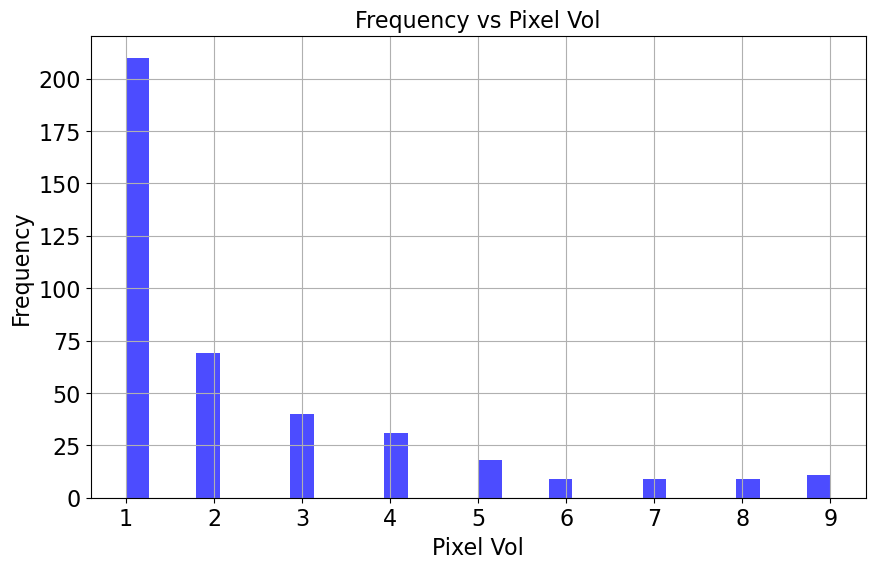

In [26]:
plot_hist('Pixel Vol', tumor_less_than_0_6_in_diameter_df)

In [122]:
def plot_tumor_count_per_study(df, bins=50, xlim=None,ylim=None):
    # tumor_per_study = filtered_non_clinical_important_tumor_df.groupby(['Patient ID', 'Study ID']).size().value_counts()
    plt.figure(figsize=(10, 6))
    plt.hist(df.groupby(['Patient ID', 'Study ID']).size().values, bins=bins, alpha=0.7, color='blue')
    plt.title('Frequency vs Tumor Count per Study', fontsize=16)
    plt.xlabel('Tumor Count per Study', fontsize=16)
    plt.ylabel('Frequency', fontsize=16) 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid(True)

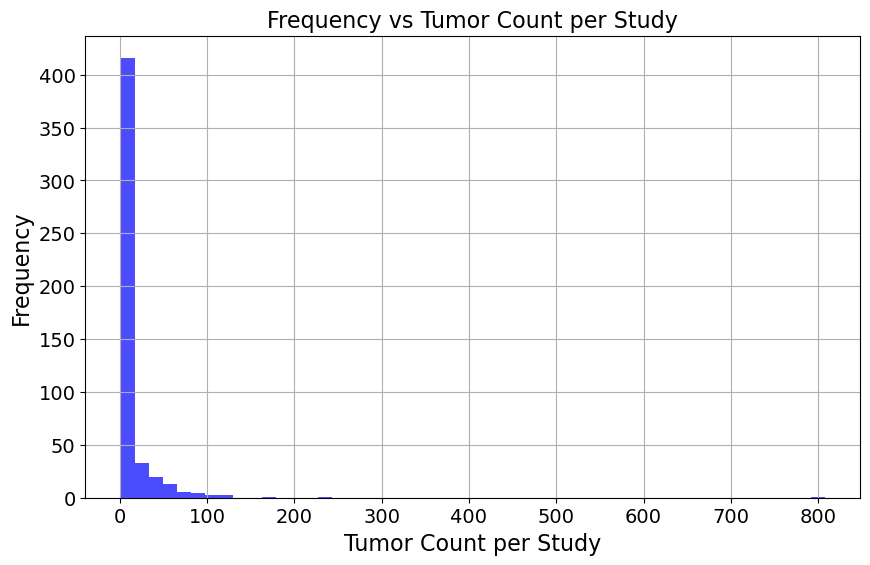

In [124]:
plot_tumor_count_per_study(filtered_non_clinical_important_tumor_df)

<h2>
We can see there is one outlier center around 800 for tumor count per study and the outlier ID is : 'PETCT_1285b86bea'

In [52]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'] == 'PETCT_1285b86bea']

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level
373,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1,108,1.3436,1.3691,11.3470,3.2805,55.4408,MELANOMA,0.6-2,>10
374,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,2,24,0.2986,0.8293,9.8334,3.6970,29.4463,MELANOMA,0.6-2,>10
375,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,3,24,0.2986,0.8293,5.7868,3.2736,12.9158,MELANOMA,0.6-2,>10
376,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,4,1170,14.5560,3.0293,18.7686,3.2800,82.8191,MELANOMA,>10,>10
377,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,5,97,1.2068,1.3209,11.1360,3.3386,44.4185,MELANOMA,0.6-2,>10
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1040,16,0.1991,0.7244,4.0380,2.6605,6.3878,MELANOMA,0.6-2,6-10
1413,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1041,18,0.2239,0.7534,4.6608,2.6889,11.1557,MELANOMA,0.6-2,>10
1414,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1042,46,0.5723,1.0301,5.0005,2.7512,12.3460,MELANOMA,0.6-2,>10
1415,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1043,14,0.1742,0.6929,3.3359,2.6720,4.3857,MELANOMA,0.6-2,3-6


<h3> Drop the outlier

In [62]:
drop_outlier_df = filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'] != 'PETCT_1285b86bea']

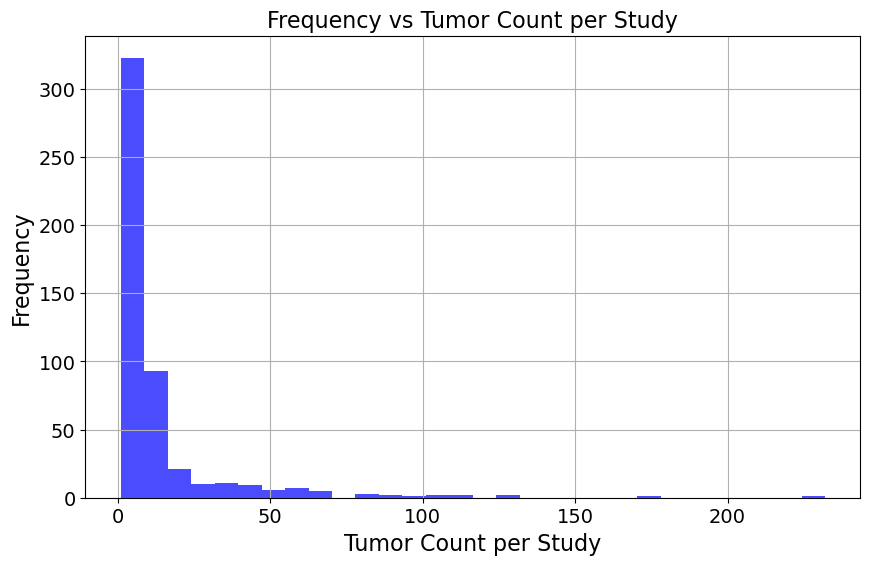

In [106]:
plot_tumor_count_per_study(drop_outlier_df)

In [90]:
def scatter_plot(feature1, feature2, df, xlim=None, ylim=None):
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df[feature1], 
                df[feature2],
                c=df['Diagnosis'].astype('category').cat.codes,  # categorize color by diagnosis
                cmap='viridis',
                alpha=0.5)

    # Add title and labels
    plt.title(feature1 + ' vs ' + feature2)
    plt.xlabel(feature1)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
#     plt.xlim(0, 200)
#     plt.ylim(0, 100)
    plt.ylabel(feature2)
    unique_labels = df['Diagnosis'].unique()
    handles = [plt.Line2D([], [], marker="o", linestyle="", color=scatter.cmap(scatter.norm(i)), label=label)
            for i, label in enumerate(unique_labels)]
    plt.legend(handles=handles, title='Diagnosis')

    # Show the plot
    plt.show()

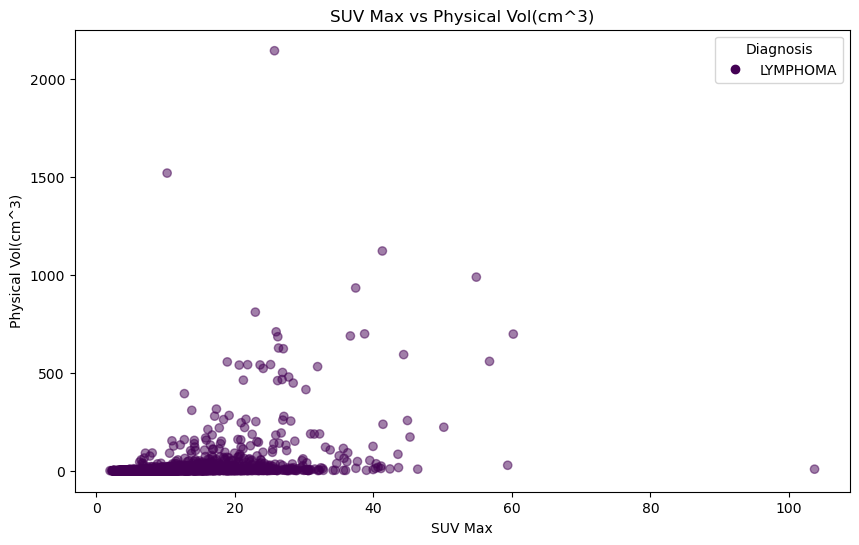

In [177]:


('SUV Max','Physical Vol(cm^3)', filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Diagnosis'] ==  'LYMPHOMA'])

In [17]:
tumor_less_than_0_6_in_diameter_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level
9,PETCT_01140d52d8,08-13-2005-NA-PET-CT Ganzkoerper primaer mit ...,5,2,0.0249,0.3622,3.2864,3.1884,3.3845,MELANOMA,0-0.04 (3 Pixel),3-6
10,PETCT_01140d52d8,08-13-2005-NA-PET-CT Ganzkoerper primaer mit ...,6,1,0.0124,0.2875,3.0760,3.0760,3.0760,MELANOMA,0-0.02(2 Pixel),3-6
11,PETCT_01140d52d8,08-13-2005-NA-PET-CT Ganzkoerper primaer mit ...,7,7,0.0871,0.5499,3.4072,3.0627,3.9520,MELANOMA,0.08- 0.1 (8 Pixel),3-6
13,PETCT_0117d7f11f,09-13-2001-NA-PET-CT Ganzkoerper primaer mit ...,2,8,0.0995,0.5750,1.7109,1.5134,1.8062,LUNG_CANCER,0.08- 0.1 (8 Pixel),0-2
31,PETCT_0223010e46,09-04-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,1,0.0124,0.2875,2.3239,2.3239,2.3239,LYMPHOMA,0-0.02(2 Pixel),2-2.5
...,...,...,...,...,...,...,...,...,...,...,...,...
9116,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,75,2,0.0249,0.3622,2.0772,2.0675,2.0869,LYMPHOMA,0-0.04 (3 Pixel),2-2.5
9117,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,76,1,0.0124,0.2875,2.1374,2.1374,2.1374,LYMPHOMA,0-0.02(2 Pixel),2-2.5
9119,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,78,5,0.0622,0.4916,2.2058,2.0690,2.3754,LYMPHOMA,0.06-0.08 (6 Pixel),2-2.5
9124,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,83,1,0.0124,0.2875,2.0877,2.0877,2.0877,LYMPHOMA,0-0.02(2 Pixel),2-2.5


In [22]:
tumor_less_than_0_6_in_diameter_df.describe()

,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
count,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,112.928380,3.231593,0.040191,0.398180,3.230737,3.082434,3.416063
std,193.818887,2.473147,0.030780,0.105004,0.987880,0.930825,1.126204
min,1.000000,1.000000,0.012400,0.287500,1.037100,0.844400,1.037500
25%,11.000000,1.000000,0.012400,0.287500,2.266550,2.158700,2.390550
50%,33.500000,2.000000,0.024900,0.362200,3.260700,3.150800,3.335900
75%,103.000000,5.000000,0.062200,0.491600,3.697000,3.416000,4.046650
max,1045.000000,9.000000,0.112000,0.598000,6.974700,6.974700,9.158200


In [202]:
filename ="study tumor being filtered.npy"
np.save(filename ,tumor_less_than_0_6_in_diameter_df[['Patient ID', "Study ID"]].drop_duplicates().values, allow_pickle=True)

In [150]:
tumor_less_than_0_6_in_diameter_df[tumor_less_than_0_6_in_diameter_df['Patient ID'] == 'PETCT_5d553bf6b4']

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
3677,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,8,1,0.0124,0.2875,1.6284,1.6284,1.6284,LUNG_CANCER
3679,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,10,6,0.0746,0.5224,1.6160,1.4991,1.7073,LUNG_CANCER


In [186]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'] == 'PETCT_fe705ea1cc']

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level
9043,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,2,1330,16.5466,3.1616,4.3937,2.0579,13.0667,LYMPHOMA,>10,>10
9044,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,3,41,0.5101,0.9913,3.5326,2.0655,7.3376,LYMPHOMA,0.6-2,6-10
9047,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,6,250,3.1103,1.8111,3.6185,2.0585,8.0881,LYMPHOMA,2-5,6-10
9048,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,7,377,4.6903,2.0768,3.5857,2.0607,7.2643,LYMPHOMA,2-5,6-10
9050,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,9,122,1.5178,1.4258,3.0861,2.0732,5.5115,LYMPHOMA,0.6-2,3-6
...,...,...,...,...,...,...,...,...,...,...,...,...
9126,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,85,123,1.5302,1.4297,3.6867,2.0710,7.7638,LYMPHOMA,0.6-2,6-10
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,85,1.0575,1.2640,3.6395,2.0594,9.8709,LYMPHOMA,0.6-2,6-10
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,100,1.2441,1.3344,2.8568,2.0629,5.6163,LYMPHOMA,0.6-2,3-6
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,75,0.9331,1.2124,3.3243,2.0933,5.3749,LYMPHOMA,0.6-2,3-6


<Figure size 1000x600 with 0 Axes>

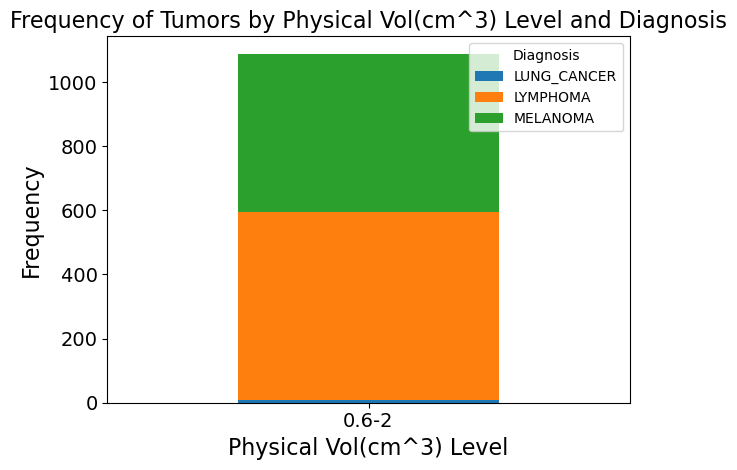

In [334]:
bins = [0, 2, 5, 10, float('inf')]

# Define the labels for the bins
labels = ['0.6-2', '2-5', '5-10', '>10']

plot_level_(bins, labels, 'Physical Vol(cm^3)',df = suspicious_small_tumor_df, hue=True)

<Figure size 1000x600 with 0 Axes>

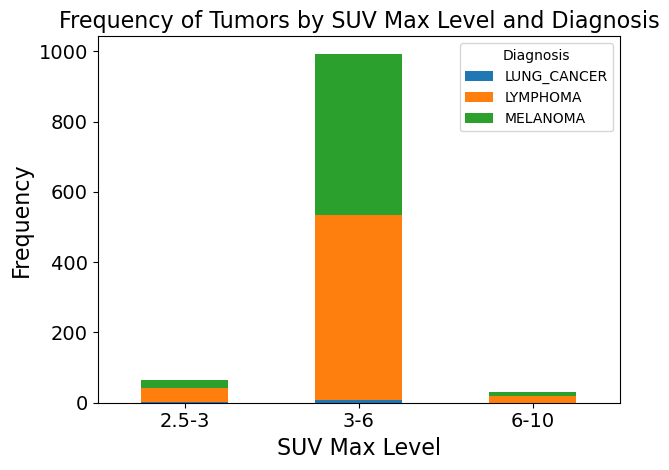

In [335]:
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]
# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']
plot_level_(bins, labels, 'SUV Max',df = suspicious_small_tumor_df, hue = True)


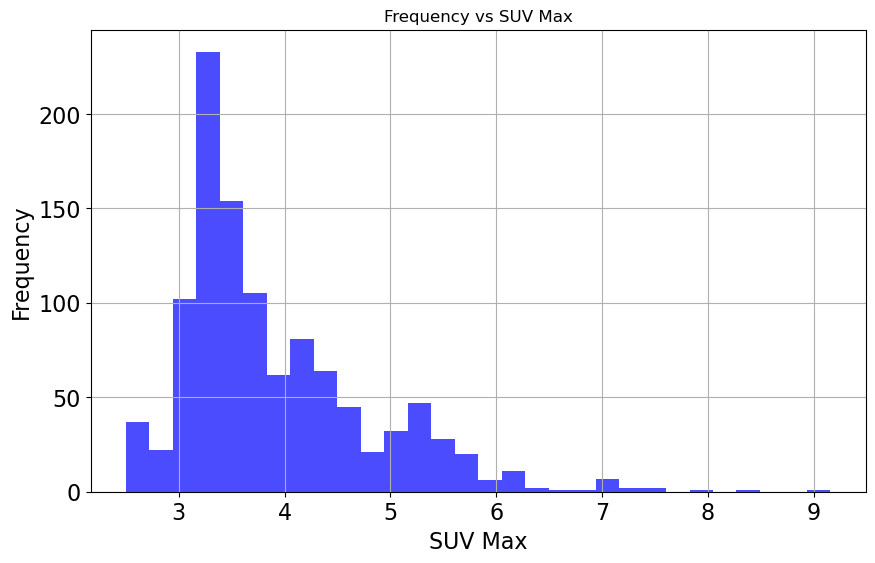

In [224]:
plot_hist('SUV Max', df = suspicious_small_tumor_df)

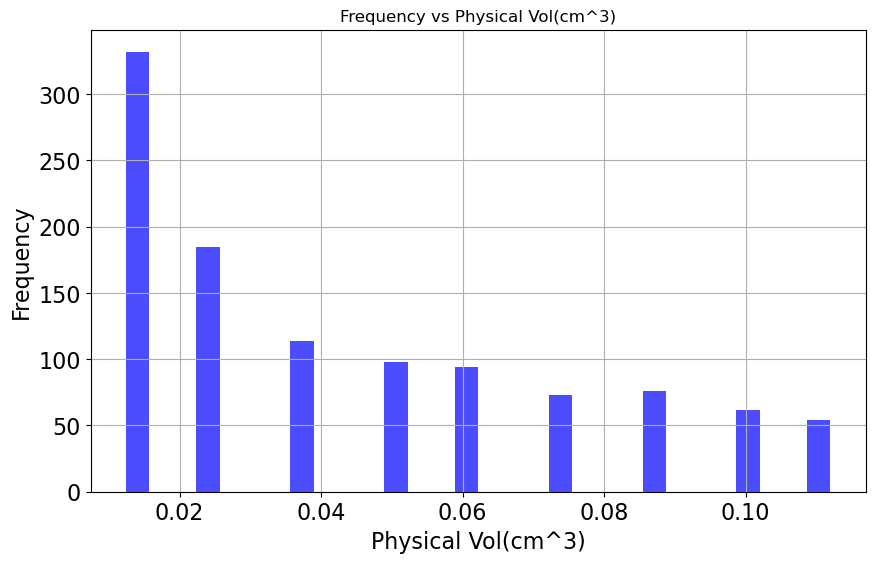

In [223]:
plot_hist('Physical Vol(cm^3)', df = suspicious_small_tumor_df)

In [ ]:
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]
# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']
plot_level_(bins, labels, 'Pixel ',df = tumor_less_than_0_6_in_diameter_df, hue = True, in_place = True)


<Figure size 1000x600 with 0 Axes>

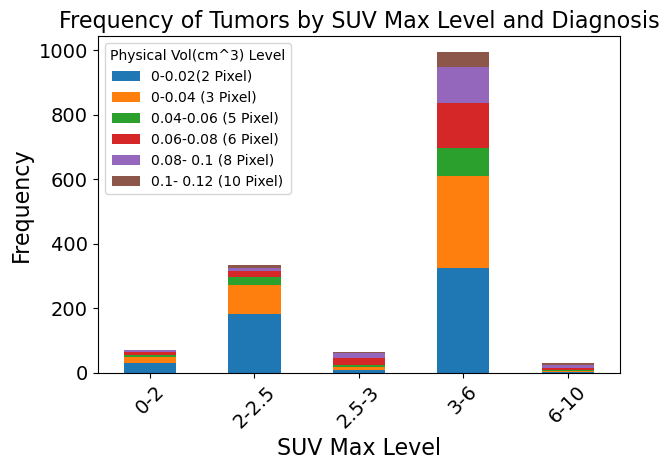

In [19]:
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]
# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']
plot_level_(bins, labels, 'SUV Max',df = tumor_less_than_0_6_in_diameter_df, hue = True, in_place = True, diagnosis_col = 'Physical Vol(cm^3) Level')


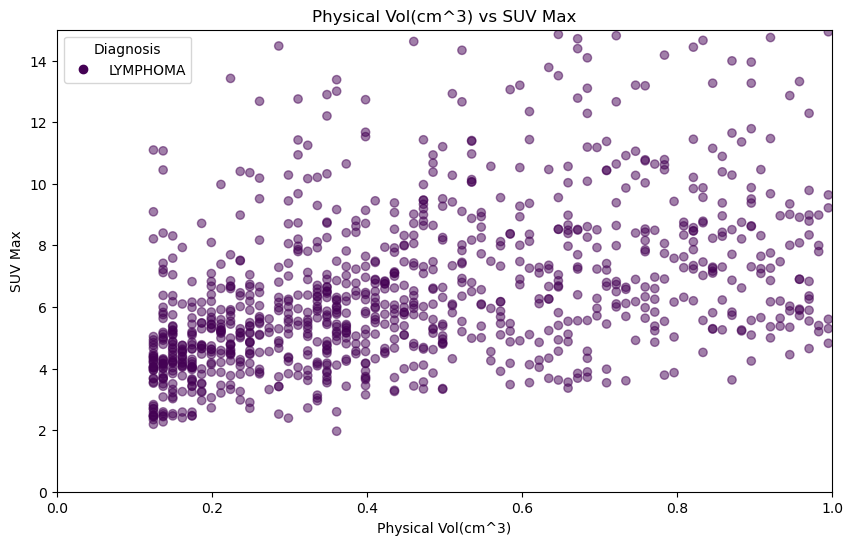

In [280]:
scatter_plot('Physical Vol(cm^3)','SUV Max',drop_outlier_df[drop_outlier_df['Diagnosis'] ==  'LYMPHOMA'], xlim=(0, 1), ylim=(0, 15))

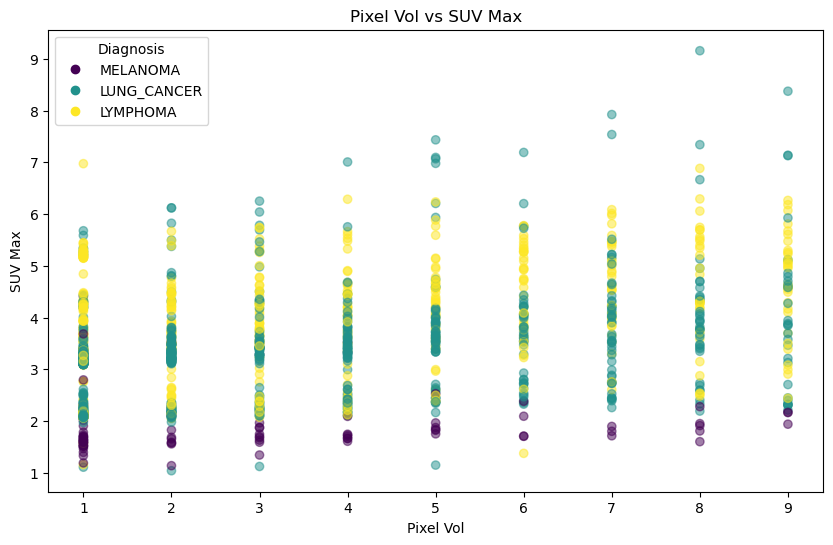

In [91]:
scatter_plot('Pixel Vol','SUV Max', tumor_less_than_0_6_in_diameter_df )

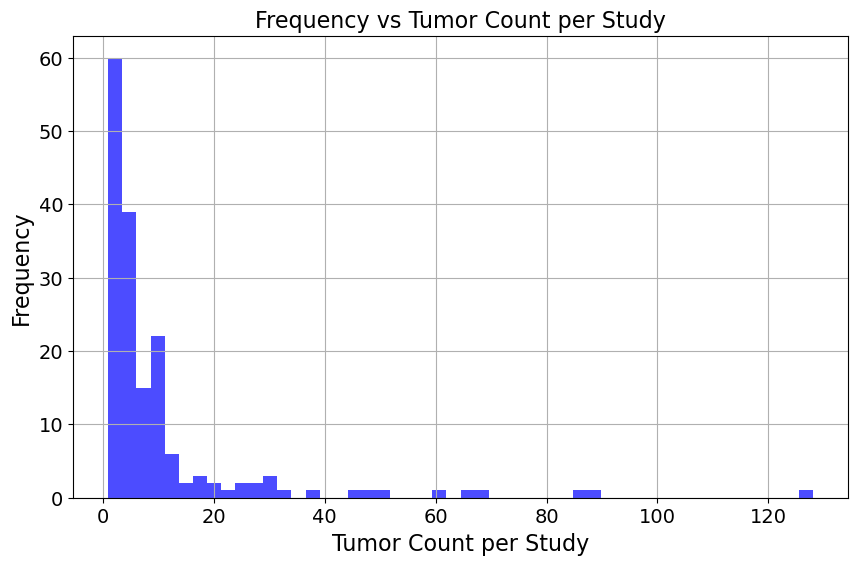

In [185]:
plot_tumor_count_per_study(filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Diagnosis'] ==  'LUNG_CANCER'])

In [56]:
def plot_heatmap(df = filtered_non_clinical_important_tumor_df, feature1 = 'SUV Max Level', feature2 = 'Physical Vol(cm^3) Level'):
    suv_max_physical_vol_heatmap_df = df.groupby([feature1, feature2]).size().reset_index(name='count')
    print(suv_max_physical_vol_heatmap_df)
    suv_max_physical_vol_pivot_df = suv_max_physical_vol_heatmap_df.pivot(index=feature1, columns= feature2, values='count')
    suv_max_physical_vol_pivot_df = suv_max_physical_vol_pivot_df.iloc[::-1]

    mask = suv_max_physical_vol_pivot_df < 1
    # Plotting the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(suv_max_physical_vol_pivot_df, annot=True, fmt='d', cmap='viridis', vmin=0, mask=mask)
    for text in ax.texts:
        text.set_weight('bold')
        text.set_color('black')

    plt.title('Heatmap of '+ feature1 +' vs ' + feature2)
    plt.show()

   SUV Max Level Physical Vol(cm^3) Level  count
0            0-2             0.1-0.2(16P)      9
1            0-2              0.2-2(160p)     17
2            0-2               2-5 (400P)      0
3            0-2               5-10(800P)      0
4            0-2           10-100 (8000P)      0
5            0-2          100-200(16000P)      0
6            0-2                     >200      0
7          2-2.5             0.1-0.2(16P)     30
8          2-2.5              0.2-2(160p)     27
9          2-2.5               2-5 (400P)      0
10         2-2.5               5-10(800P)      0
11         2-2.5           10-100 (8000P)      0
12         2-2.5          100-200(16000P)      0
13         2-2.5                     >200      0
14         2.5-3             0.1-0.2(16P)     27
15         2.5-3              0.2-2(160p)     63
16         2.5-3               2-5 (400P)      1
17         2.5-3               5-10(800P)      1
18         2.5-3           10-100 (8000P)      0
19         2.5-3    

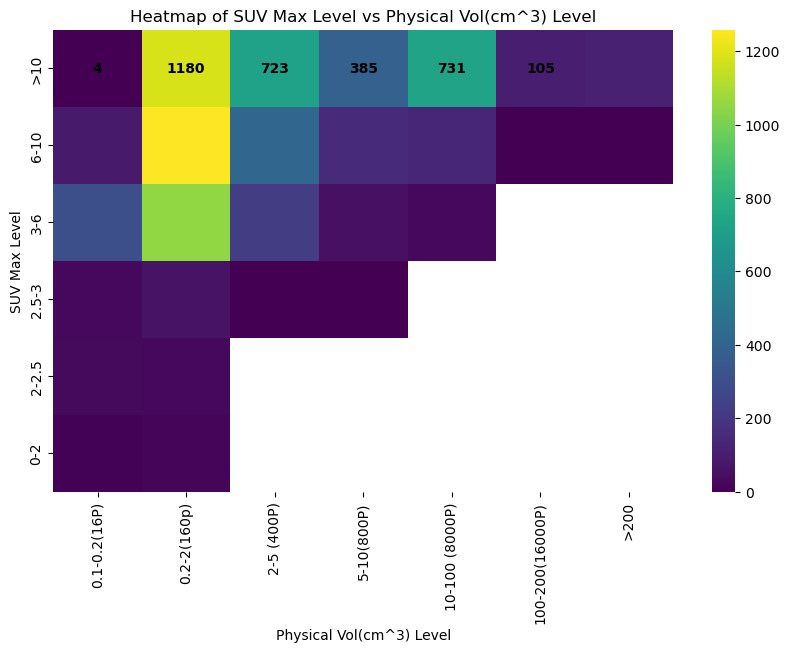

In [74]:
plot_heatmap()

   SUV Max Level Physical Vol(cm^3) Level  count
0            0-2          0-0.02(2 Pixel)     29
1            0-2         0-0.04 (3 Pixel)     19
2            0-2      0.04-0.06 (5 Pixel)      6
3            0-2      0.06-0.08 (6 Pixel)      9
4            0-2      0.08- 0.1 (8 Pixel)      7
5            0-2     0.1- 0.12 (10 Pixel)      1
6          2-2.5          0-0.02(2 Pixel)    181
7          2-2.5         0-0.04 (3 Pixel)     90
8          2-2.5      0.04-0.06 (5 Pixel)     25
9          2-2.5      0.06-0.08 (6 Pixel)     18
10         2-2.5      0.08- 0.1 (8 Pixel)     11
11         2-2.5     0.1- 0.12 (10 Pixel)     10
12         2.5-3          0-0.02(2 Pixel)      8
13         2.5-3         0-0.04 (3 Pixel)      8
14         2.5-3      0.04-0.06 (5 Pixel)      9
15         2.5-3      0.06-0.08 (6 Pixel)     19
16         2.5-3      0.08- 0.1 (8 Pixel)     17
17         2.5-3     0.1- 0.12 (10 Pixel)      3
18           3-6          0-0.02(2 Pixel)    323
19           3-6    

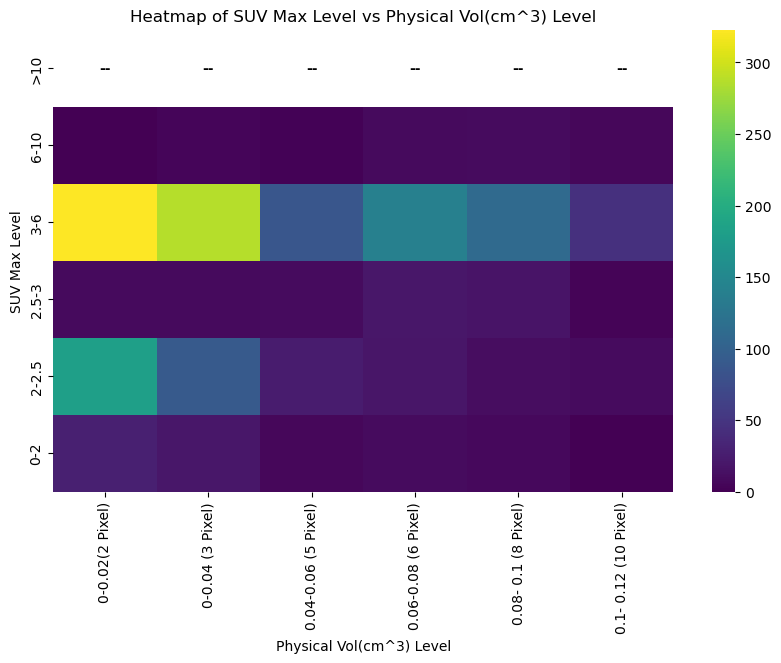

In [58]:
plot_heatmap(df = tumor_less_than_0_6_in_diameter_df)

   SUV Max Level Physical Vol(cm^3) Level  count
0            0-2                    0.6-2      1
1            0-2                      2-5      0
2            0-2                     5-10      0
3            0-2                      >10      0
4          2-2.5                    0.6-2     14
5          2-2.5                      2-5      0
6          2-2.5                     5-10      0
7          2-2.5                      >10      0
8          2.5-3                    0.6-2     19
9          2.5-3                      2-5      0
10         2.5-3                     5-10      0
11         2.5-3                      >10      0
12           3-6                    0.6-2    537
13           3-6                      2-5     20
14           3-6                     5-10      7
15           3-6                      >10      1
16          6-10                    0.6-2    554
17          6-10                      2-5    139
18          6-10                     5-10     47
19          6-10    

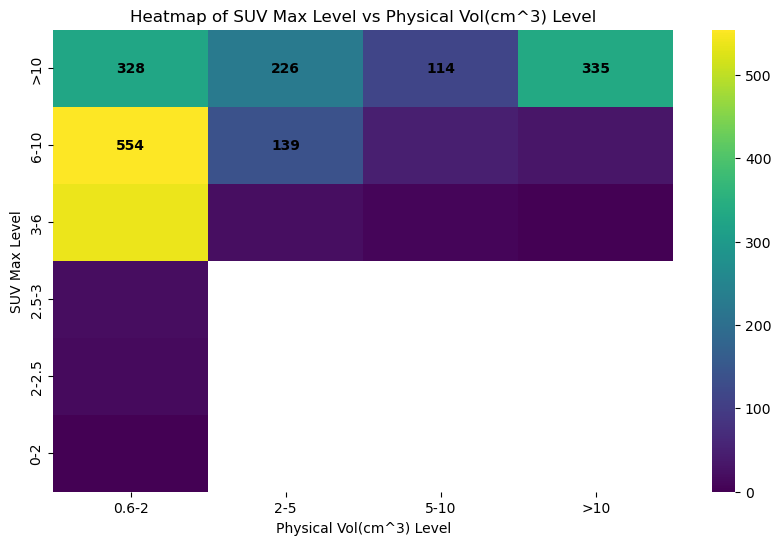

In [327]:
plot_heatmap(filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Diagnosis'] ==  'LYMPHOMA'])

In [1]:
import nibabel as nib
# suv_file_path = '/Users/wenyuanchen/Desktop/IBM/IBM_Tumor_Project/Data/PETCT_0b57b247b6/05-02-2002-NA-PET-CT Ganzkoerper  primaer mit KM-42966/SUV.nii.gz'
suv_file_path = '/Users/wenyuanchen/Desktop/IBM/IBM_Tumor_Project/Data/PETCT_f21755a99b/05-05-2005-NA-PET-CT Ganzkoerper  primaer mit KM-44651/SUV.nii.gz'
seg_file_path = '/Users/wenyuanchen/Desktop/IBM/IBM_Tumor_Project/Data/PETCT_f21755a99b/05-05-2005-NA-PET-CT Ganzkoerper  primaer mit KM-44651/SEG.nii.gz'
suv_img = nib.load(suv_file_path)
seg_img = nib.load(seg_file_path)
suv_data = suv_img.get_fdata()
seg_data = seg_img.get_fdata()

In [2]:
def sample_3x3x3_block_full_of_0s(seg_data, block_size=(3, 3, 3)):
    max_attempts = 10000
    attempt = 0
    block_found = False

    while attempt < max_attempts and not block_found:
        # Generate random starting indices
        start_x = np.random.randint(0, seg_data.shape[0] - 2)  # -2 to include the end index for a 3x3x3 block
        start_y = np.random.randint(0, seg_data.shape[1] - 2)
        start_z = np.random.randint(0, seg_data.shape[2] - 2)

        # Extract the 3x3x3 block
        block = seg_data[start_x:start_x+block_size[0], start_y:start_y+block_size[1], start_z:start_z+block_size[2]]

        # Check if the block contains only 1s
        if np.all(block == 0):
            block_found = True
            return block, (start_x, start_y, start_z), attempt + 1  # Return block, starting position, and attempts

        attempt += 1

    return None, None, attempt  # Return None if no block found after max attempts

# Attempt to sample a 3x3x3 block full of 1s from the array
def get_suv_block(suv_data, position, block_size=(3, 3, 3)):
    start_x, start_y, start_z = position
    end_x = start_x + block_size[0]
    end_y = start_y + block_size[1]
    end_z = start_z + block_size[2]
    block = suv_data[start_x:end_x, start_y:end_y, start_z:end_z]
    return block

In [3]:
block, position, attempt = sample_3x3x3_block_full_of_0s(seg_data)
suv_block = get_suv_block(suv_data, position)

NameError: name 'np' is not defined

In [92]:
suv_block

array([[[0.00066037, 0.00061099, 0.00078789],
        [0.00082547, 0.00081465, 0.00078789],
        [0.00115565, 0.00244395, 0.00131316]],

       [[0.00082547, 0.00081465, 0.00078789],
        [0.00115565, 0.00101831, 0.00078789],
        [0.00148584, 0.00264762, 0.00157579]],

       [[0.00132075, 0.00081465, 0.00052526],
        [0.00181603, 0.00101831, 0.00052526],
        [0.00198112, 0.00224029, 0.00131316]]])

In [6]:
from utils import get_connected_components_3D

import numpy as np
from utils import *
from tqdm import tqdm
def get_max_min_xyz_of_mask(binary_mask):
    # Find the non-zero indicesxs
    non_zero_indices = np.argwhere(binary_mask > 0)

    # Find min and max coordinates
    xmin, ymin, zmin = non_zero_indices.min(axis=0)
    xmax, ymax, zmax = non_zero_indices.max(axis=0)

    return {"x_min_coordinate": xmin, "y_min_coordinate": ymin, "z_min_coordinate": zmin, 
            "x_max_coordinate": xmax, "y_max_coordinate": ymax, "z_max_coordinate": zmax}
def get_tumor_under_threshold_block_coordinate(seg_mask, block_size = (3, 3, 3)):
    coordinates = get_max_min_xyz_of_mask(seg_mask)
    x_min, y_min, z_min = coordinates["x_min_coordinate"], coordinates["y_min_coordinate"], coordinates["z_min_coordinate"]
    x_max, y_max, z_max = coordinates["x_max_coordinate"], coordinates["y_max_coordinate"], coordinates["z_max_coordinate"]
    # Calculate the center coordinates
    x_center = (x_min + x_max) // 2
    y_center = (y_min + y_max) // 2
    z_center = (z_min + z_max) // 2

    # Calculate half sizes for each dimension, adjusting for even sizes
    half_size_x = block_size[0] // 2
    half_size_y = block_size[1] // 2
    half_size_z = block_size[2] // 2

    x_start = max(x_center - half_size_x, 0)
    x_end = min(x_start + block_size[0], seg_mask.shape[0])
    y_start = max(y_center - half_size_y, 0)
    y_end = min(y_start + block_size[1], seg_mask.shape[1])
    z_start = max(z_center - half_size_z, 0)
    z_end = min(z_start + block_size[2], seg_mask.shape[2])

    # Correct the start positions if the block exceeds the mask dimensions
    if x_end - x_start < block_size[0]: x_start = x_end - block_size[0]
    if y_end - y_start < block_size[1]: y_start = y_end - block_size[1]
    if z_end - z_start < block_size[2]: z_start = z_end - block_size[2]
    return x_start, y_start, z_start
def get_tumor_under_threshold_block(coordinates, suv_data, block_size = (3, 3, 3)):
    x_start, y_start, z_start = coordinates
    x_end = x_start + block_size[0]
    y_end = y_start + block_size[1]
    z_end = z_start + block_size[2]
    block = suv_data[x_start:x_end, y_start:y_end, z_start:z_end]
    assert block.shape == block_size, f"Block shape is wrong and currently has shape of : {block.shape}"
    return block

def get_tumor_under_threshold_blocks_per_study(separate_seg_masks, suv_data, size_threshold = 3, block_size = (3, 3, 3)):
    block_lst = []
    coordinate_lst= []
    for mask in tqdm(separate_seg_masks):
        voxel = np.sum(mask)
        if voxel <= size_threshold:
            coordinates = get_tumor_under_threshold_block_coordinate(mask, block_size)
            block = get_tumor_under_threshold_block(coordinates, suv_data, block_size)
            block_lst.append(block)
            coordinate_lst.append(coordinates)
    return block_lst, coordinate_lst
    
    


In [7]:
separate_seg_masks = get_connected_components_3D(seg_data, connectivity=26)
coordinate_lst = get_tumor_under_threshold_blocks_per_study(separate_seg_masks, suv_data, size_threshold = 3, block_size = (3, 3, 3))

100%|██████████| 20/20 [00:02<00:00,  9.83it/s]
